# pyGIMLi(emg3d) Example

In [1]:
%matplotlib widget

In [2]:
import os
import pooch
import emg3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use('bmh')

from emg3d.inversion.pygimli import Kernel, Inversion

# Adjust this path to a folder of your choice.
data_path = os.path.join('..', 'download', '')

## Fetch the model

Retrieve and load the pre-computed resistivity model.



In [3]:
fname = "GemPy-I.h5"
pooch.retrieve(
    'https://raw.github.com/emsig/data/2021-05-21/emg3d/models/'+fname,
    '06f522a69c94dc02ca3da0ea4ca7b60f7a9c764cdcbf6699ef4155621d70b3bb',
    fname=fname,
    path=data_path,
)
fmodel = emg3d.load(data_path + fname)['model']
smodel = emg3d.Model(fmodel.grid, 1/fmodel.property_x, mapping='Conductivity')
fgrid = fmodel.grid

Data loaded from «/home/dtr/Codes/download/GemPy-I.h5»
[emg3d v1.0.0rc3.dev5+g0cd9e09 (format 1.0) on 2021-05-21T14:06:32.551618].


## QC resistivity model



In [4]:
target_inds = (
    (fgrid.cell_centers[:, 0] > 1400) &
    (fgrid.cell_centers[:, 0] < 4000) &
    (fgrid.cell_centers[:, 1] > -540) &
    (fgrid.cell_centers[:, 1] < 2500) &
    (fgrid.cell_centers[:, 2] > -900) &
    (fgrid.cell_centers[:, 2] <= -750)
).reshape(fmodel.shape, order='F')

fmodel.property_x[(fmodel.property_x==50) & target_inds] = 1000

In [5]:
from scipy.interpolate import RectBivariateSpline

seafloor = np.ones((fgrid.shape_cells[0], fgrid.shape_cells[1]))
for i in range(fgrid.shape_cells[0]):
    for ii in range(fgrid.shape_cells[1]):
        # We take the seafloor to be the first cell which resistivity
        # is below 0.5
        nodes = fgrid.nodes_z[:-1][fmodel.property_x[i, ii, :] < 0.5]
        if nodes.size > 0:
            seafloor[i, ii] = nodes[0]

# Create a 2D interpolation function from it
bathymetry = RectBivariateSpline(
        fgrid.cell_centers_x, fgrid.cell_centers_y, seafloor)

In [6]:
# Angles for horizontal, x-directed Ex point dipoles
elevation = 0.0
azimuth = 0.0

# Acquisition source frequencies (Hz)
frequencies = [0.5, 1.0]

# Source coordinates
src_x = [1500, 4500]
src_y = 1000
# Source depths: 50 m above seafloor
src_z = bathymetry(src_x, src_y).ravel()+50
src = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.TxElectricDipole,
        (src_x, src_y, src_z, azimuth, elevation)
)

# Receiver positions
rec_x = np.arange(1, 6)*1000
rec_y = np.arange(3)*1000
RX, RY = np.meshgrid(rec_x, rec_y, indexing='ij')
RZ = bathymetry(rec_x, rec_y)
rec = emg3d.surveys.txrx_coordinates_to_dict(
        emg3d.RxElectricPoint,
        (RX.ravel(), RY.ravel(), RZ.ravel(), azimuth, elevation)
)

In [7]:
survey = emg3d.surveys.Survey(
    name='GemPy-II Survey A',  # Name of the survey
    sources=src,               # Source coordinates
    receivers=rec,             # Receiver coordinates
    frequencies=frequencies,   # Two frequencies
    # data=data,               # If you have observed data
    noise_floor=1e-15,
    relative_error=0.05,
)

# Let's have a look at the survey:
survey

:: Survey «GemPy-II Survey A» ::

<xarray.Dataset> Size: 1kB
Dimensions:   (src: 2, rec: 15, freq: 2)
Coordinates:
  * src       (src) <U6 48B 'TxED-1' 'TxED-2'
  * rec       (rec) <U7 420B 'RxEP-01' 'RxEP-02' ... 'RxEP-14' 'RxEP-15'
  * freq      (freq) <U3 24B 'f-1' 'f-2'
Data variables:
    observed  (src, rec, freq) complex128 960B (nan+nanj) ... (nan+nanj)
Attributes:
    noise_floor:     1e-15
    relative_error:  0.05

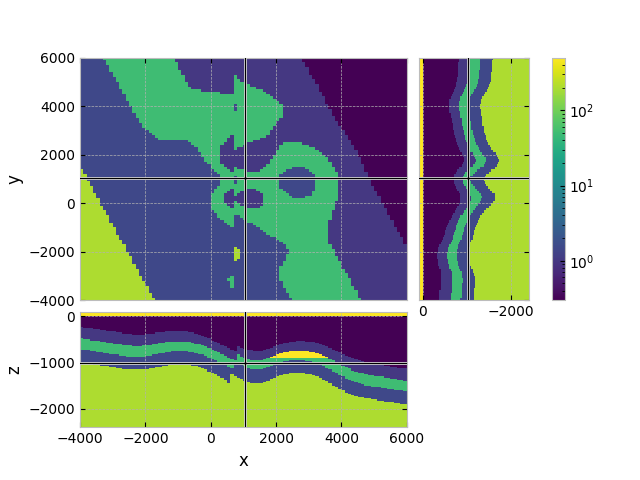

In [8]:
fgrid.plot_3d_slicer(
    fmodel.property_x, zslice=-1000,
    pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=500)}
)

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')

## Compute some example CSEM data with it



In [9]:
# Source:  x-directed electric-source at (1000, 1000, -500)
src_coo = [1000, 1000, -500, 0, 0]
frequency = 1.0  # Hz

# Computational grid
gopts = {
    'frequency': frequency,
    'center': src_coo[:3],
    'properties': [0.3, 200, 1000],
    'domain': ([1500, 4000], [-1000, 3000], [-2000, 0]),
    'seasurface': 0,
    'center_on_edge': False,
}

simulation = emg3d.simulations.Simulation(
    survey=survey,        # Our survey instance
    model=fmodel,          # The model
    gridding='single',      # Frequency- and source-dependent meshes
    max_workers=4,        # How many parallel jobs
    # solver_opts,        # Any parameter to pass to emg3d.solve
    gridding_opts=gopts,  # Gridding options
    receiver_interpolation='linear',
)

# Let's QC our
simulation.compute(observed=True)

Compute efields            0/4  [00:00]

Text(0, 0.5, '$|E_x|$ (V/m)')

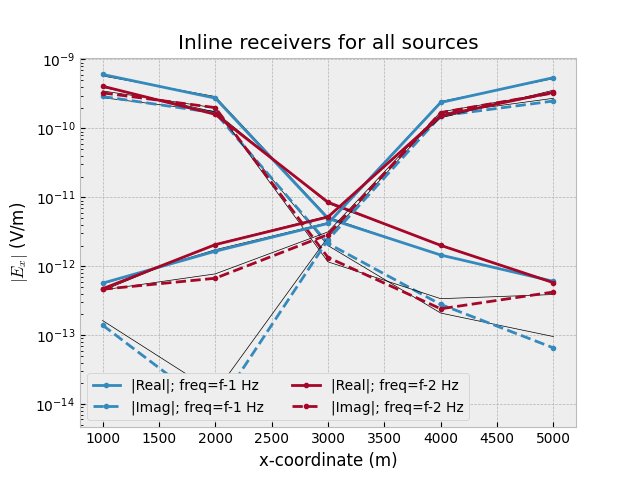

In [10]:
plt.figure()
plt.title("Inline receivers for all sources")
obs = simulation.data.observed[:, 1::3, :]
syn = simulation.data.synthetic[:, 1::3, :]
for i, src in enumerate(survey.sources.keys()):
    for ii, freq in enumerate(survey.frequencies):
        plt.plot(rec_coords[0][1::3],
                 abs(syn.loc[src, :, freq].data.real),
                 "k-", lw=0.5)
        plt.plot(rec_coords[0][1::3],
                 abs(syn.loc[src, :, freq].data.imag),
                 "k-", lw=0.5)
        plt.plot(rec_coords[0][1::3],
                 abs(obs.loc[src, :, freq].data.real),
                 f"C{ii}.-",
                 label=f"|Real|; freq={freq} Hz" if i == 0 else None
                 )
        plt.plot(rec_coords[0][1::3],
                 abs(obs.loc[src, :, freq].data.imag),
                 f"C{ii}.--",
                 label=f"|Imag|; freq={freq} Hz" if i == 0 else None
                 )

plt.yscale('log')
plt.legend(ncol=2, framealpha=1)
plt.xlabel('x-coordinate (m)')
plt.ylabel('$|E_x|$ (V/m)')

In [11]:
igrid = emg3d.TensorMesh([np.ones(22)*200, np.ones(12)*200, np.ones(25)*100], origin=(800, -200, -2400))
imodel = smodel.interpolate_to_grid(igrid)
imodel

Model: conductivity; isotropic; 22 x 12 x 25 (6,600)

In [12]:
simulation.clean('computed')

gopts['mapping'] = 'Conductivity'
sim = emg3d.simulations.Simulation(
    survey=simulation.survey,        # Our survey instance
    model=imodel,          # The model
    gridding='both',      # Frequency- and source-dependent meshes
    max_workers=4,        # How many parallel jobs
    #solver_opts,        # Any parameter to pass to emg3d.solve
    gridding_opts=gopts,  # Gridding options
    tqdm_opts=False,
    receiver_interpolation='linear',
)

In [13]:
check = fmodel.interpolate_to_grid(igrid)

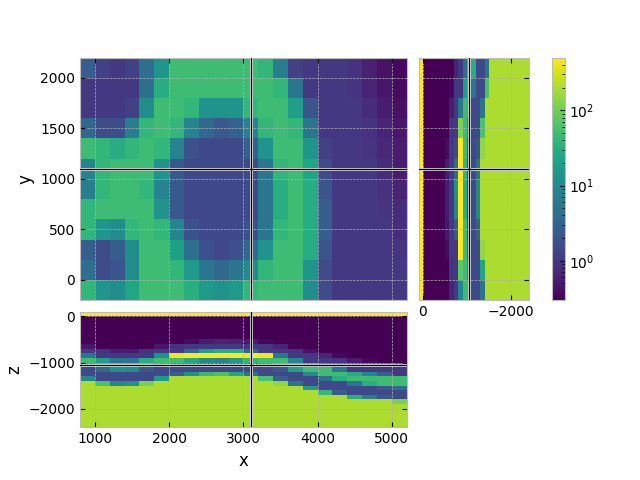

In [14]:
igrid.plot_3d_slicer(
    check.property_x, zslice=-1000,
    pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=500)}
)

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')

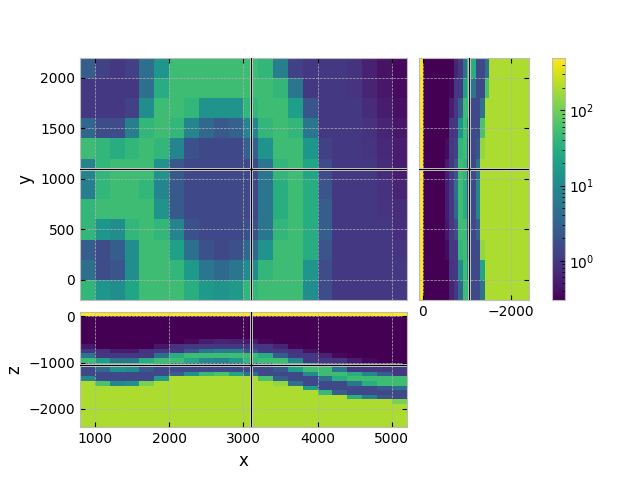

In [15]:
igrid.plot_3d_slicer(
    1/imodel.property_x, zslice=-1000,
    pcolor_opts={'norm': LogNorm(vmin=0.3, vmax=500)}
)

# Plot survey in figure above
fig = plt.gcf()
fig.suptitle('Resistivity model (Ohm.m) and survey layout')
axs = fig.get_children()
rec_coords = survey.receiver_coordinates()
src_coords = survey.source_coordinates()
axs[1].plot(rec_coords[0], rec_coords[1], 'bv')
axs[2].plot(rec_coords[0], rec_coords[2], 'bv')
axs[3].plot(rec_coords[2], rec_coords[1], 'bv')
axs[1].plot(src_coords[0], src_coords[1], 'r*')
axs[2].plot(src_coords[0], src_coords[2], 'r*')
axs[3].plot(src_coords[2], src_coords[1], 'r*')

In [16]:
# Create region markers (as many different regions as you like)
markers = np.zeros(imodel.shape, dtype=int)
#markers[:, :, grid.cell_centers_z > -500] = 1     # top two layers and bottom two layers
markers[check.property_x == 1000.0] = 1            # Only target is free
#markers = np.zeros(model_start.shape, dtype=int)
#markers[1:-1, :, :][:, 1:-1, :][:, :, 1:-2] = 1

# Instantiate the emg3d-kernel for pyGIMLi
fop = Kernel(simulation=sim, markers=markers, pgthreads=1)

# Instantiate the inversion and set some inversion parameters
INV = Inversion(fop=fop)
INV.inv.setCGLSTolerance(10)  # is _absolute_, not _relative_
INV.inv.setMaxCGLSIter(30)
#INV.dataTrans = pg.trans.TransSymLog(sim.survey.noise_floor)

# Set the regions.
# Any number of regions is possible; alse `fix=True`, `single=True`, and `background=True`.
# Two different ways of the same: INV.setRegularization; INV.fop.setRegionProperties
INV.fop.setRegionProperties(1, single=True, limits=(0.0001, 2), startModel=1.0)  # Target
INV.fop.setRegionProperties(0, background=True)                                               # Background

# Constrain types (cType)
# 0 only damping (minimum length; only useful with good starting model and isReference=True in INV)
# 1 1st deriv - smoothing
# 2 2nd deriv
# 10, 20 - mixed form

# Depth weighting
# https://www.pygimli.org/_examples_auto/4_gravimetry_magnetics/plot_08_inv-magnetics-3d.html#depth-weighting

In [17]:
#INV.stopAtChi1 = False
errmodel = INV.run(
    #maxIter=2, # just to test
    lam=1,  # btw 1-100
    #verbose=True,
    #debug=True,
    #startModel=model_true.property_x.ravel('F'),
    #isReference=True,
)

09/07/24 - 13:01:02 - pyGIMLi - INFO - :: pyGIMLi(emg3d) START ::
09/07/24 - 13:01:02 - pyGIMLi - INFO - Created startmodel from region infos: 1 [1.0]
09/07/24 - 13:01:02 - pyGIMLi - INFO - 0: χ² =   72.73; λ = 1.0;  1 kernel call(s); ϕ = 8727.70 + 0.00·λ = 8727.70
09/07/24 - 13:01:47 - pyGIMLi - INFO - 1: χ² =   70.82; λ = 1.0; 64 kernel call(s); ϕ = 8497.98 + 21.95·λ = 8519.93; Δϕ = 2.38%
09/07/24 - 13:02:30 - pyGIMLi - INFO - 2: χ² =   70.82; λ = 1.0; 66 kernel call(s); ϕ = 8498.20 + 21.90·λ = 8520.11; Δϕ = -0.00%
09/07/24 - 13:03:17 - pyGIMLi - INFO - 3: χ² =   70.82; λ = 1.0; 66 kernel call(s); ϕ = 8498.43 + 21.85·λ = 8520.28; Δϕ = -0.00%
09/07/24 - 13:03:17 - pyGIMLi - INFO - :: pyGIMLi(emg3d) END   :: runtime = 0:02:15


In [18]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Tue Jul 09 13:03:17 2024 CEST

                OS : Linux (Ubuntu 22.04)
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
               RAM : 31.0 GiB
       Environment : Jupyter
       File system : ext4

  Python 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC
  12.3.0]

             numpy : 1.26.4
             scipy : 1.14.0
             numba : 0.59.1
             emg3d : 1.8.4.dev5+g326f68d.d20240705
           empymod : 2.3.1
            xarray : 2024.6.0
        discretize : 0.10.0
              h5py : 3.11.0
        matplotlib : 3.9.1
              tqdm : 4.66.4
           IPython : 8.26.0
           pygimli : 1.5.1+49.gf1569841
            pgcore : 1.5.0
--------------------------------------------------------------------------------